In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()           # ignore errors if already unmounted

#If cannot remount, simply delete the mounted drive and then remount
# rm -rf /content/drive


In [2]:
# Colab cell
from google.colab import drive

drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [3]:
# Adjust these two for YOUR repo
REPO_OWNER = "ywanglab"
REPO_NAME  = "STAT4160"   # e.g., unified-stocks-team1
BASE_DIR   = "/content/drive/MyDrive/dspt25"
CLONE_DIR  = f"{BASE_DIR}/{REPO_NAME}"
REPO_URL   = f"https://github.com/{REPO_OWNER}/{REPO_NAME}.git"

# if on my office computer

# REPO_NAME  = "lectureNotes"   # e.g., on my office computer
# BASE_DIR = r"E:\OneDrive - Auburn University Montgomery\teaching\AUM\STAT 4160 Productivity Tools" # on my office computer
# CLONE_DIR  = f"{BASE_DIR}\{REPO_NAME}"

import os, pathlib
pathlib.Path(BASE_DIR).mkdir(parents=True, exist_ok=True)


In [4]:
import os, subprocess, shutil, pathlib

if not pathlib.Path(CLONE_DIR).exists():
    !git clone {REPO_URL} {CLONE_DIR}
else:
    # If the folder exists, just ensure it's a git repo and pull latest
    os.chdir(CLONE_DIR)
    # !git status
    # !git pull --rebase # !git pull --ff-only
os.chdir(CLONE_DIR)
print("Working dir:", os.getcwd())

Working dir: /content/drive/MyDrive/dspt25/STAT4160


## Session 15 — Framing & Metrics

### Learning goals

By the end of class, students can:

1.  Specify **forecast horizon** $H$, **step** (stride), and choose between **expanding** vs **sliding** rolling‑origin evaluation with an **embargo** gap.
2.  Implement a **date‑based splitter** that yields `(train_idx, val_idx)` for all tickers at once.
3.  Compute **MAE**, **sMAPE**, **MASE** (with a proper **training‑window scale**), and aggregate **per‑ticker** and **across tickers** (macro vs micro/weighted).
4.  Produce a tidy CSV of baseline results to serve as your course’s ground truth.

------------------------------------------------------------------------

## Agenda

-    forecasting setup — horizon $H$, step, rolling‑origin (expanding vs sliding), embargo
-    metrics — MAE, sMAPE, MASE; aggregation across tickers (macro vs micro/weighted)
-    **In‑class lab**: implement a date‑based splitter → compute naive & seasonal‑naive baselines → MAE/sMAPE/MASE per split/ticker → save reports
-    Wrap‑up & homework brief
-    Buffer

------------------------------------------------------------------------



### Framing the forecast

-   **Target:** next‑day log return $r_{t+1}$ (you built this as `r_1d`).

-   **Horizon** $H$: 1 business day.

-   **Step (stride):** how far the **origin** moves forward each split (e.g., 63 trading days ≈ a quarter).

-   **Rolling‑origin schemes**

    -   **Expanding:** train start fixed; **train grows** over time.
    -   **Sliding (rolling):** fixed‑length train window **slides** forward.

-   **Embargo:** small **gap** (e.g., 5 days) between train end and validation start to avoid adjacency leakage.

### Metrics (scalar, easy to compare)

-   **MAE:** $\frac{1}{n}\sum |y - \hat{y}|$ — robust & interpretable.

-   **sMAPE:** $\frac{2}{n}\sum \frac{|y - \hat{y}|}{(|y| + |\hat{y}| + \epsilon)}$ — scale‑free, safe for near‑zero returns with $\epsilon$.

-   **MASE (Mean Abs. Scaled Error) :** $\text{MASE}=\frac{\text{MAE}_\text{model}}{\text{MAE}_\text{naive (train)}}$ — \<1 means better than naive.

    -   For seasonality $s$, the **naive comparator** predicts $y_{t+1} \approx y_{t+1-s}$ (we’ll use $s=5$ for day‑of‑week seasonality on business days).
    -   **Scale** is computed on the **training window only**, per ticker.

**MASE (Mean Absolute Scaled Error)** is a scale-free accuracy metric used to evaluate forecasting models.

$$
\text{MASE} = \frac{\text{MAE}_{\text{model}}}{\text{MAE}_{\text{naive (train)}}}
$$


* **(\text{MAE}_{\text{model}})** — the **mean absolute error** of your model’s forecasts, computed over the test (or validation) set:
$$
  \text{MAE}*{\text{model}} = \frac{1}{n} \sum*{t=1}^n |y_t - \hat{y}_t|
$$

* **(\text{MAE}_{\text{naive (train)}})** — the mean absolute error of a **naive forecast** (usually a “no-change” or “random walk” model) computed on the **training data**, often defined as:
  [
  \text{MAE}*{\text{naive (train)}} = \frac{1}{T-1} \sum*{t=2}^{T} |y_t - y_{t-1}|
  ]
  where (y_t) is the training series and (T) is its length.

---

### Interpretation

* **MASE = 1** → your model performs *equally* to the naive model.
* **MASE < 1** → your model performs *better* (lower error) than the naive baseline.
* **MASE > 1** → your model performs *worse* than the naive baseline.

---

### Why MASE is useful

* It is **scale-independent** (unlike RMSE or MAE), so it can be compared across series with different units or magnitudes.
* It remains **well-defined** even when data have seasonality or non-stationary variance (with proper scaling).
* It provides an **intuitive benchmark**: if MASE < 1, your model beats the simplest possible forecast.



### Aggregation across tickers

-   **Per‑ticker metrics** first → then aggregate.
-   **Macro average:** mean of per‑ticker metrics (each ticker equal weight).
-   **Micro/weighted:** pool all rows (or weight tickers by sample count); for MAE, pooled MAE equals sample‑count weighted average of per‑ticker MAEs.

------------------------------------------------------------------------



## MAPE — *Mean Absolute Percentage Error*

###  Definition

$$
\text{MAPE} = \frac{100%}{n} \sum_{t=1}^{n}
\left| \frac{y_t - \hat{y}_t}{y_t} \right|
$$

Where:

* $ y_t $ = true (actual) value at time ( t )
* $ \hat{y}_t $ = predicted (forecasted) value
* $ n $ = number of observations


* Lower is better.
* Example: MAPE = 5% → on average, predictions are off by 5%.

---

###  Example

| Time | Actual (y_t) | Forecast (\hat{y}_t) | Absolute % Error |
| ---- | ------------ | -------------------- | ---------------- |
| 1    | 100          | 105                  | 5%               |
| 2    | 200          | 180                  | 10%              |
| 3    | 150          | 155                  | 3.33%            |

[
\text{MAPE} = \frac{(5 + 10 + 3.33)}{3} = 6.11%
]

---

###  Limitations of MAPE

1. **Division by zero problem:**
   If any ( y_t = 0 ), MAPE is undefined (division by zero).
2. **Asymmetry:**
   Over-predictions and under-predictions are penalized **unequally** in percentage terms.
   (e.g., predicting 50 instead of 100 = 50% error, but predicting 200 instead of 100 = 100% error.)
3. **Biased for small actual values:**
   When actual values are near zero, MAPE can explode to very large values.

---

## sMAPE — *Symmetric Mean Absolute Percentage Error*

To fix MAPE’s asymmetry, people use **sMAPE**, defined as:

$$
\text{sMAPE} =
\frac{100%}{n} \sum_{t=1}^{n}
\frac{|\hat{y}_t - y_t|}{(|y_t| + |\hat{y}_t|)/2}
$$

or equivalently:
$$
\text{sMAPE} =
\frac{200%}{n} \sum_{t=1}^{n}
\frac{|\hat{y}_t - y_t|}{|y_t| + |\hat{y}_t|}
$$



* The denominator uses the *average of actual and predicted* values —
  making the metric **symmetric** (over- and under-prediction penalized equally).
* Scale is still percentage-based.

 **Interpretation**

* 0% = perfect forecast
* 100% = prediction is completely off (in typical scaling)

---

### Example (same data)

| Time | Actual (y_t) | Forecast (\hat{y}_t) | sMAPE component |    |                       |
| ---- | ------------ | -------------------- | --------------- | -- | --------------------- |
| 1    | 100          | 105                  | ( 2×            | 5  | /(100+105) = 4.88% )  |
| 2    | 200          | 180                  | ( 2×            | 20 | /(200+180) = 10.53% ) |
| 3    | 150          | 155                  | ( 2×            | 5  | /(150+155) = 3.27% )  |
$$
\text{sMAPE} = (4.88 + 10.53 + 3.27)/3 = 6.23%
$$



---

## TL;DR

| Metric    | Meaning                                                                           | Key Idea                                             |
| --------- | --------------------------------------------------------------------------------- | ---------------------------------------------------- |
| **MAPE**  | Mean Absolute Percentage Error                                                    | Average % deviation from actual values               |
| **sMAPE** | Symmetric MAPE                                                                    | Same idea, but symmetric and avoids division by zero |
| **Tip**   | Use sMAPE for production forecasting metrics — it’s fairer and numerically safer. |                                                      |

---




## In‑class lab (35 min, Colab‑friendly)



```python
np.r_[np.nan, np.diff(np.log(adj))]
```

### In words:

> “Take the **logarithm** of the array `adj`, compute its **first differences**, and then **prepend a NaN** so that the output has the same length as the original series.”

Assume you have:

```python
import numpy as np
adj = np.array([100, 105, 102, 110], dtype=float)
```


```python
np.log(adj)
# → [4.60517, 4.65400, 4.62497, 4.70048]
```

This is common in finance — we often use **log prices** because:

* differences of logs approximate **returns**,
* and logs make multiplicative changes additive.

---

###  `np.diff(np.log(adj))`

Computes the **difference between consecutive elements**.

```python
np.diff(np.log(adj))
# → [0.04883, -0.02903, 0.07551]
```

Mathematically:
$$
\text{diff}_t = \log(\text{adj}_t) - \log(\text{adj}_{t-1})
$$
which equals:
$$
\log\left(\frac{\text{adj}_t}{\text{adj}_{t-1}}\right)
$$
→ this is the **log return** between days (t-1) and (t).

---

###  `np.r_[np.nan, ...]`

`np.r_[]` concatenates arrays row-wise.

Here, you’re prepending a single `np.nan` (Not-a-Number) value before the differences:

```python
np.r_[np.nan, np.diff(np.log(adj))]
# → [nan, 0.04883, -0.02903, 0.07551]
```

This aligns the array with your original data length.
Since there’s no previous day to compute a return for the **first** element, it’s set to `NaN`.



##  Equivalent longer version

```python
log_prices = np.log(adj)
diffs = np.diff(log_prices)
log_returns = np.insert(diffs, 0, np.nan)
```





In [6]:
import os, pathlib, numpy as np, pandas as pd
from pathlib import Path

# Load returns or create a tiny fallback
rpath = Path("data/processed/returns.parquet")
if rpath.exists():
    returns = pd.read_parquet(rpath)
else:
    # Fallback synthetic returns for 5 tickers, 320 business days
    rng = np.random.default_rng(0)
    dates = pd.bdate_range("2022-01-03", periods=320)
    frames=[]
    for tkr in ["AAPL","MSFT","GOOGL","AMZN","NVDA"]:
        eps = rng.normal(0, 0.012, size=len(dates)).astype("float32")
        adj = 100*np.exp(np.cumsum(eps))
        df = pd.DataFrame({
            "date": dates,
            "ticker": tkr,
            "adj_close": adj.astype("float32"),
            "log_return": np.r_[np.nan, np.diff(np.log(adj))].astype("float32")
        })
        df["r_1d"] = df["log_return"].shift(-1)
        df["weekday"] = df["date"].dt.weekday.astype("int8")
        df["month"]   = df["date"].dt.month.astype("int8")
        frames.append(df)
    returns = pd.concat(frames, ignore_index=True).dropna().reset_index(drop=True)
    returns["ticker"] = returns["ticker"].astype("category")
    returns.to_parquet(rpath, index=False)

# Standardize
returns["date"] = pd.to_datetime(returns["date"])
returns = returns.sort_values(["ticker","date"]).reset_index(drop=True)
returns["ticker"] = returns["ticker"].astype("category")
returns.head()


,date,ticker,log_return,r_1d,weekday,month
0,2020-01-01,AAPL,NaN,0.002987,2,1
1,2020-01-02,AAPL,0.002987,-0.002741,3,1
2,2020-01-03,AAPL,-0.002741,-0.008906,4,1
3,2020-01-06,AAPL,-0.008906,-0.004547,0,1
4,2020-01-07,AAPL,-0.004547,-0.009916,1,1


In [7]:
len(returns["date"].unique() ), returns['date'].min(), returns['date'].max()

(180, Timestamp('2020-01-01 00:00:00'), Timestamp('2020-09-08 00:00:00'))

### 1) Rolling‑origin date splitter (expanding windows + embargo)

In [8]:
import numpy as np, pandas as pd

def make_rolling_origin_splits(dates: pd.Series,
                               train_min=252,   # ~1y of trading days
                               val_size=63,     # ~1 quarter
                               step=63,
                               embargo=5):
    """Return a list of (train_start, train_end, val_start, val_end) date tuples."""
    u = np.array(sorted(pd.to_datetime(dates.unique())))
    n = len(u)
    splits=[]
    i = train_min - 1
    while True:
        if i >= n: break
        tr_start, tr_end = u[0], u[i] # note the start does not change, expanding training window
        vs_idx = i + embargo + 1
        ve_idx = vs_idx + val_size - 1
        if ve_idx >= n: break
        splits.append((tr_start, tr_end, u[vs_idx], u[ve_idx]))
        i += step
    return splits

def splits_to_indices(df, split):
    """Map a date split to index arrays for the full multi-ticker frame."""
    a,b,c,d = split
    tr_idx = df.index[(df["date"]>=a) & (df["date"]<=b)].to_numpy()
    va_idx = df.index[(df["date"]>=c) & (df["date"]<=d)].to_numpy()
    # sanity: embargo => last train date < first val date
    assert b < c
    return tr_idx, va_idx

splits = make_rolling_origin_splits(returns["date"], train_min= 100, val_size=21, step=21, embargo=5)
len(splits), splits[:3]

(3,
 [(Timestamp('2020-01-01 00:00:00'),
   Timestamp('2020-05-19 00:00:00'),
   Timestamp('2020-05-27 00:00:00'),
   Timestamp('2020-06-24 00:00:00')),
  (Timestamp('2020-01-01 00:00:00'),
   Timestamp('2020-06-17 00:00:00'),
   Timestamp('2020-06-25 00:00:00'),
   Timestamp('2020-07-23 00:00:00')),
  (Timestamp('2020-01-01 00:00:00'),
   Timestamp('2020-07-16 00:00:00'),
   Timestamp('2020-07-24 00:00:00'),
   Timestamp('2020-08-21 00:00:00'))])

### 2) Metrics & baseline predictors (naive and seasonal‑naive)

In [9]:
from typing import Dict, Tuple

def mae(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat);
    return float(np.mean(np.abs(y - yhat)))

def smape(y, yhat, eps=1e-8):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return float(np.mean(2.0*np.abs(y - yhat)/(np.abs(y)+np.abs(yhat)+eps)))

def mase(y_true, y_pred, y_train_true, y_train_naive):
    # Scale = MAE of comparator (naive) on TRAIN only; add tiny epsilon
    scale = mae(y_train_true, y_train_naive) + 1e-12
    return float(mae(y_true, y_pred) / scale)

def add_baseline_preds(df: pd.DataFrame, seasonality:int=5) -> pd.DataFrame:
    """
    For each ticker:
      - naive predicts r_{t+1} ≈ log_return_t (s=1)
      - seasonal naive (s) predicts r_{t+1} ≈ log_return_{t+1-s}  => shift(s-1)
    Adds columns: yhat_naive, yhat_s{s}
    """
    out = df.copy()
    # out["yhat_naive"] = out.groupby("ticker")["log_return"].transform(lambda s: s)  # s=1  this is not a naive predict
    out["yhat_naive"] = out.groupby("ticker")["log_return"].shift(1)
    if seasonality <= 1:
        out["yhat_s"] = out["yhat_naive"]
    else:
        out["yhat_s"] = out.groupby("ticker")["log_return"].transform(lambda s: s.shift(seasonality-1))
    return out

# Apply a (possibly custom) function to a column (or multiple columns).


##  1. **Using `.apply()`**

### **(a) On a single column**

```python
df["col2"] = df["col1"].apply(myfunc)
```

* Applies `myfunc(x)` to each element in column `"col1"`.
* Example:

  ```python
  df["sqrt"] = df["x"].apply(lambda x: np.sqrt(x))
  ```

---

### **(b) On the whole DataFrame**

```python
df.apply(myfunc)
```

* Passes **each column (Series)** to `myfunc` by default.
* Example: sum each column

  ```python
  df.apply(np.sum)
  ```
* To apply row-wise instead:

  ```python
  df.apply(myfunc, axis=1)
  ```

---

##  2. **Using `.map()`** (for Series only)

```python
df["col2"] = df["col1"].map(myfunc)
```

* Works like `.apply()` but only for **Series**.
* Slightly faster for element-wise transformations.
* Can also take a **dict** or **Series** for mapping values:

  ```python
  df["col2"] = df["col1"].map({"A": 1, "B": 2})
  ```

---

## 3. **Using `.transform()`**

```python
df["col2"] = df.groupby("group")["x"].transform(myfunc)
```

* Similar to `.apply()`, but:

  * Returns a **Series with the same index** (so it aligns with the original DataFrame).
  * Useful for creating **new columns** after group-wise operations.
* Example: standardize each group

  ```python
  df["z"] = df.groupby("ticker")["x"].transform(lambda s: (s - s.mean()) / s.std())
  ```

---

##  4. **Using `.agg()` (aggregation)**

```python
df.groupby("ticker")["x"].agg(myfunc)
```

* Used when you want **a single summary value** per group.
* Example:

  ```python
  df.groupby("ticker")["volume"].agg(["mean", "std"])
  ```
* For custom aggregators:

  ```python
  df.groupby("ticker")["x"].agg(lambda s: np.median(s[s > 0]))
  ```

---

##  5. **Using vectorized NumPy / pandas operations**

If your function supports **vectorization**, apply it directly without loops:

```python
df["log_return"] = np.log(df["adj_close"] / df["adj_close"].shift(1))
```

* Fastest and most efficient.
* Always prefer this when possible.

---

##  6. **Using `.assign()` for chaining**

When working in a **method chain**:

```python
df = (
    df.assign(
        log_return = lambda d: np.log(d["adj_close"] / d["adj_close"].shift(1)),
        zscore = lambda d: (d["x"] - d["x"].mean()) / d["x"].std()
    )
)
```

* Keeps transformations declarative and chainable.

---

###  Summary Table

| Method         | Works on                    | Returns same shape? | Group-aware? | Typical Use                    |
| :------------- | :-------------------------- | :------------------ | :----------- | :----------------------------- |
| `.map()`       | Series                      | ✅                   | ❌            | elementwise mapping            |
| `.apply()`     | Series/DataFrame            | ❌                   | ❌            | flexible elementwise / rowwise |
| `.transform()` | Series (often with groupby) | ✅                   | ✅            | feature engineering per group  |
| `.agg()`       | Series/DataFrame (grouped)  | ❌                   | ✅            | aggregation / summarization    |
| Vectorized ops | Series/DataFrame            | ✅                   | ❌            | fastest arithmetic ops         |
| `.assign()`    | DataFrame                   | ✅                   | ❌            | method chaining                |

---



 `.agg()` (or `.aggregate()`) **can assign new column names** when you:

* (a) pass a dictionary mapping old column names → new (function) names, or
* (b) use a list of named tuples (or lambda aliases), or
* (c) use keyword arguments (new in pandas ≥1.3).

---

###  Example DataFrame

```python
import pandas as pd
import numpy as np

# Simulate daily log returns for 3 tickers
np.random.seed(0)
out = pd.DataFrame({
    "ticker": np.repeat(["AAPL", "MSFT", "TSLA"], 5),
    "date": pd.date_range("2025-01-01", periods=5).tolist() * 3,
    "adj_close": np.random.uniform(90, 110, 15) #[90, 100)
})
```

---

###  Vectorized operation (fastest)

Compute log returns directly:

```python
out["log_return"] = np.log(out["adj_close"] / out.groupby("ticker")["adj_close"].shift(1))
```

 Vectorized, efficient, same shape as original DataFrame.

---

###  `.map()` — elementwise on a single column

Add a column with absolute log returns:

```python
out["abs_return"] = out["log_return"].map(lambda x: abs(x) if pd.notna(x) else np.nan)
```

 Works per element.

---

###  `.apply()` — apply function to each column or row

Suppose we want a column “rank_within_row” that ranks values across columns per row:

```python
out["rank_within_row"] = out[["adj_close", "abs_return"]].apply(
    lambda row: row.rank().iloc[0], axis=1
)
```
 Row-wise apply (axis=1).

---

###  `.transform()` — group-wise feature creation

Compute **z-scores** within each ticker:

```python
out["zscore"] = out.groupby("ticker")["log_return"].transform(
    lambda s: (s - s.mean()) / s.std()
)
```
 Returns same shape as original — can assign directly as new column.

---

###  `.agg()` — grouped aggregation (with new column names)

Compute **mean and std** of log returns per ticker:

```python
summary = (
    out.groupby("ticker")["log_return"]
       .agg(mean_return=("mean"), std_return=("std"))
       .reset_index()
)
```
 Renames columns automatically (`mean_return`, `std_return`).

You can also use a dict:

```python
summary = out.groupby("ticker").agg({
    "log_return": ["mean", "std"],
    "adj_close": "last"
})
summary.columns = ["mean_return", "std_return", "last_price"]
summary = summary.reset_index()
```

 Multi-level columns flattened and renamed.

---

###  Result (illustrative)

| ticker | mean_return | std_return | last_price |
| :----- | ----------: | ---------: | ---------: |
| AAPL   |      0.0021 |     0.0183 |      101.7 |
| MSFT   |     -0.0044 |     0.0145 |       99.8 |
| TSLA   |      0.0062 |     0.0210 |      108.2 |

---

###  Key takeaway

| Method         | Best for                     | Shape      | Example                                     |
| :------------- | :--------------------------- | :--------- | :------------------------------------------ |
| Vectorized     | Fast math ops                | same       | $\log(\text{price}*t / \text{price}*{t-1})$ |
| `.map()`       | Elementwise (Series)         | same       | `abs_return = log_return.map(abs)`          |
| `.apply()`     | Row/column-wise custom logic | may change | rank rows                                   |
| `.transform()` | Group-wise new features      | same       | z-score per ticker                          |
| `.agg()`       | Group summaries              | reduced    | mean/std by ticker                          |




In [10]:
# Precompute predictions over the entire frame once (safe: uses only past values via shift)
seasonality = 5  # business-day weekly
preds_all = add_baseline_preds(returns, seasonality=seasonality)

def per_ticker_metrics(df_val, df_train, method="naive") -> pd.DataFrame:
    """
    Compute per-ticker MAE, sMAPE, MASE for the chosen method ('naive' or 's').
    MASE scale uses TRAIN window and the same comparator as method.
    """
    rows=[]
    col = "yhat_naive" if method=="naive" else "yhat_s"
    for tkr, g in df_val.groupby("ticker"): #.groupby("ticker", observed=True) to suppress the warning, see the explanations below.
        gv = g.dropna(subset=["r_1d", col])
        if len(gv)==0:
            continue
        # TRAIN scale (per ticker)
        gt = df_train[df_train["ticker"]==tkr].dropna(subset=["r_1d"])
        if method=="naive":
            gt_pred = gt["log_return"]  # s=1
        else:
            gt_pred = gt["log_return"].shift(seasonality-1)
        gt_clean = gt.dropna(subset=["r_1d"]).copy()
        gt_pred = gt_pred.loc[gt_clean.index]  #align index
        gt_clean = gt_clean.dropna(subset=["r_1d"])
        # Align indices
        y_tr = gt_clean["r_1d"].to_numpy()
        yhat_tr_naive = gt_pred.to_numpy()
        # VAL metrics
        y = gv["r_1d"].to_numpy()
        yhat = gv[col].to_numpy()
        rows.append({
            "ticker": tkr,
            "n": int(len(y)),
            "mae": mae(y,yhat),
            "smape": smape(y,yhat),
            "mase": mase(y, yhat, y_tr, yhat_tr_naive),
        })
    return pd.DataFrame(rows)

def aggregate_across_tickers(per_ticker_df: pd.DataFrame) -> Dict[str,float]:
    if per_ticker_df.empty:
        return {"macro_mae":np.nan,"macro_smape":np.nan,"macro_mase":np.nan,
                "micro_mae":np.nan,"micro_smape":np.nan,"micro_mase":np.nan}
    # Macro = unweighted mean across tickers
    macro = per_ticker_df[["mae","smape","mase"]].mean().to_dict()
    # Micro/weighted by n (pooled)
    w = per_ticker_df["n"].to_numpy()
    micro = {
        "micro_mae": float(np.average(per_ticker_df["mae"], weights=w)), #weighted avg
        "micro_smape": float(np.average(per_ticker_df["smape"], weights=w)),
        "micro_mase": float(np.average(per_ticker_df["mase"], weights=w)),
    }
    return {f"macro_{k}": float(v) for k,v in macro.items()} | micro  # `|` combine two dictionarys, see explanations below

# Run on 2 splits in class; you can expand later
import pathlib, json
pathlib.Path("reports").mkdir(exist_ok=True)
rows=[]
for sid, split in enumerate(splits[:2], start=1):
    a,b,c,d = split
    tr_idx, va_idx = splits_to_indices(returns, split)
    tr = preds_all.loc[tr_idx].copy()
    va = preds_all.loc[va_idx].copy()
    # Per-ticker metrics for two baselines
    pt_naive = per_ticker_metrics(va, tr, method="naive")
    pt_s     = per_ticker_metrics(va, tr, method="s")
    agg_naive = aggregate_across_tickers(pt_naive)
    agg_s     = aggregate_across_tickers(pt_s)
    # Save per-split, per-ticker
    pt_naive.to_csv(f"reports/baseline_naive_split{sid}.csv", index=False)
    pt_s.to_csv(f"reports/baseline_s{seasonality}_split{sid}.csv", index=False)
    rows.append({
        "split": sid,
        "train_range": f"{a.date()}→{b.date()}",
        "val_range": f"{c.date()}→{d.date()}",
        "method": "naive", **agg_naive  # **agg_naive: dictionary expansion (see below for explanations)
    })
    rows.append({
        "split": sid,
        "train_range": f"{a.date()}→{b.date()}",
        "val_range": f"{c.date()}→{d.date()}",
        "method": f"s{seasonality}", **agg_s
    })

summary = pd.DataFrame(rows)
summary.to_csv("reports/baselines_rollingorigin_summary.csv", index=False)
summary

/tmp/ipython-input-576091926.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["yhat_naive"] = out.groupby("ticker")["log_return"].shift(1)
/tmp/ipython-input-576091926.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["yhat_s"] = out.groupby("ticker")["log_return"].transform(lambda s: s.shift(seasonality-1))
/tmp/ipython-input-2415967549.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for tkr, g in df

,split,train_range,val_range,method,macro_mae,macro_smape,macro_mase,micro_mae,micro_smape,micro_mase
0,1,2020-01-01→2020-05-19,2020-05-27→2020-06-24,naive,0.010735,1.423151,NaN,0.010735,1.423151,NaN
1,1,2020-01-01→2020-05-19,2020-05-27→2020-06-24,s5,0.011337,1.494447,NaN,0.011337,1.494447,NaN
2,2,2020-01-01→2020-06-17,2020-06-25→2020-07-23,naive,0.011808,1.508472,NaN,0.011808,1.508472,NaN
3,2,2020-01-01→2020-06-17,2020-06-25→2020-07-23,s5,0.011226,1.436448,NaN,0.011226,1.436448,NaN


### 3) Evaluate baselines across **first 2 splits** (fast in class)

In [11]:
rows

[{'split': 1,
  'train_range': '2020-01-01→2020-05-19',
  'val_range': '2020-05-27→2020-06-24',
  'method': 'naive',
  'macro_mae': 0.010735292844474316,
  'macro_smape': 1.4231508731842042,
  'macro_mase': nan,
  'micro_mae': 0.010735292844474316,
  'micro_smape': 1.4231508731842042,
  'micro_mase': nan},
 {'split': 1,
  'train_range': '2020-01-01→2020-05-19',
  'val_range': '2020-05-27→2020-06-24',
  'method': 's5',
  'macro_mae': 0.011336738504469394,
  'macro_smape': 1.4944465637207032,
  'macro_mase': nan,
  'micro_mae': 0.011336738504469394,
  'micro_smape': 1.4944465637207032,
  'micro_mase': nan},
 {'split': 2,
  'train_range': '2020-01-01→2020-06-17',
  'val_range': '2020-06-25→2020-07-23',
  'method': 'naive',
  'macro_mae': 0.01180816862732172,
  'macro_smape': 1.5084718370437622,
  'macro_mase': nan,
  'micro_mae': 0.01180816862732172,
  'micro_smape': 1.5084718370437622,
  'micro_mase': nan},
 {'split': 2,
  'train_range': '2020-01-01→2020-06-17',
  'val_range': '2020-06-2

### **What the warning means**

Whenever you call something like:

```python
out.groupby("ticker")["log_return"].transform(lambda s: s)
```

or

```python
for tkr, g in df_val.groupby("ticker"):
```

pandas internally uses:

```python
observed=False
```

by default — meaning:

> If your grouping key(s) come from a *categorical column*, pandas includes **all possible category levels**, even those **not present** in the data.

However, in a **future pandas version**, the default will become:

```python
observed=True
```

meaning:

> Only the categories actually *observed* in your data will be included.

---

###  **How to silence the warning now**

You can explicitly set `observed` in all your `groupby()` calls.

**Option 1 (keep current behavior — include unobserved categories):**

```python
out.groupby("ticker", observed=False)
```

**Option 2 (adopt future behavior — include only observed categories):**

```python
out.groupby("ticker", observed=True)
```




### ** The `|` operator (dictionary merge)**

Since **Python 3.9**, the `|` operator merges dictionaries:

```python
a | b
```

is equivalent to:

```python
{**a, **b}
```

* Keys from `b` override those in `a` if duplicates exist.
* It creates a **new** merged dictionary (does not modify either input).

So here:

```python
{f"macro_{k}": float(v) for k,v in macro.items()} | micro
```

means

> “Return one dictionary that contains *all macro metrics* (with prefixed names) and *all micro metrics*.”

---

###  ** Example result**

If

```python
macro = {"mae": 0.014, "smape": 0.12, "mase": 0.9}
micro = {"micro_mae": 0.0138, "micro_smape": 0.115, "micro_mase": 0.92}
```

then

```python
{f"macro_{k}": float(v) for k,v in macro.items()} | micro
```

returns

```python
{
  "macro_mae": 0.014,
  "macro_smape": 0.12,
  "macro_mase": 0.9,
  "micro_mae": 0.0138,
  "micro_smape": 0.115,
  "micro_mase": 0.92
}
```




The `**` operator in a function call or literal like this is called **dictionary unpacking** (or **dictionary expansion**).

It takes all the **key–value pairs** from a dictionary and inserts them as if they were written explicitly.

---

###  Example

If you have:

```python
agg_naive = {
    "macro_mae": 0.012,
    "macro_smape": 0.11,
    "macro_mase": 0.85
}
```

then writing:

```python
{
    "split": 1,
    "method": "naive",
    **agg_naive
}
```

is equivalent to:

```python
{
    "split": 1,
    "method": "naive",
    "macro_mae": 0.012,
    "macro_smape": 0.11,
    "macro_mase": 0.85
}
```


### 4) Quick sanity assertions (no overlap; embargo honored)

In [12]:
def check_no_overlap(df, split):
    a,b,c,d = split
    assert b < c, f"Embargo violation: train_end {b} >= val_start {c}"
    tr_idx, va_idx = splits_to_indices(df, split)
    assert set(tr_idx).isdisjoint(set(va_idx))
    return True

all(check_no_overlap(returns, s) for s in splits[:2]), len(summary)

(True, 4)

## Wrap‑up

-   You now have a **date‑based rolling‑origin splitter** with an **embargo**, and **baseline metrics** that set a credible reference.
-   **MASE** uses a **training‑window naive** as scale (per ticker), so you can read “\<1 is better than naive” at a glance.
-   Aggregation: report both **macro** (per‑ticker average) and **micro/weighted** (pooled).

------------------------------------------------------------------------

## Homework (due before Session 16)

**Goal:** Build a small CLI to reproduce these baselines over **all splits**, then generate per‑ticker & aggregated tables.

### Part A — Script: `scripts/baselines_eval.py`

In [41]:
# save to scripts/baselines_eval.py
#!/usr/bin/env python
from __future__ import annotations # dont interprete the type hints (see explanation below)
import argparse, numpy as np, pandas as pd
from pathlib import Path

def mae(y,yhat): return float(np.mean(np.abs(np.asarray(y)-np.asarray(yhat))))
def smape(y,yhat,eps=1e-8):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return float(np.mean(2*np.abs(y-yhat)/(np.abs(y)+np.abs(yhat)+eps)))
def mase(y_true, y_pred, y_train_true, y_train_naive):
    return float(mae(y_true, y_pred) / (mae(y_train_true, y_train_naive)+1e-12))

def make_splits(dates, train_min, val_size, step, embargo):
    u = np.array(sorted(pd.to_datetime(dates.unique()))); n=len(u); out=[]; i=train_min-1
    while True:
        if i>=n: break
        a,b = u[0], u[i]; vs = i + embargo + 1; ve = vs + val_size - 1
        if ve>=n: break
        out.append((a,b,u[vs],u[ve])); i += step
    return out

def add_preds(df, s):
    out = df.copy()
    out["yhat_naive"] = out.groupby("ticker")["log_return"].transform(lambda x: x)
    out["yhat_s"] = out.groupby("ticker")["log_return"].transform(lambda x: x.shift(s-1)) if s>1 else out["yhat_naive"]
    return out

def per_ticker(df_val, df_train, method, s):
    col = "yhat_naive" if method=="naive" else "yhat_s"
    rows=[]
    for tkr, g in df_val.groupby("ticker"):
        gv = g.dropna(subset=["r_1d", col])
        if len(gv)==0: continue
        gt = df_train[df_train["ticker"]==tkr].dropna(subset=["r_1d"])
        gt_pred = gt["log_return"] if method=="naive" else gt["log_return"].shift(s-1)
        gt_pred = gt_pred.loc[gt.index]
        y_tr = gt["r_1d"].to_numpy(); yhat_tr = gt_pred.to_numpy()
        y = gv["r_1d"].to_numpy(); yhat = gv[col].to_numpy()
        rows.append({"ticker":tkr,"n":int(len(y)),
                     "mae": mae(y,yhat),
                     "smape": smape(y,yhat),
                     "mase": mase(y,yhat,y_tr,yhat_tr)})
    return pd.DataFrame(rows)

def agg(pt):
    if pt.empty: return {"macro_mae":np.nan,"macro_smape":np.nan,"macro_mase":np.nan,
                         "micro_mae":np.nan,"micro_smape":np.nan,"micro_mase":np.nan}
    macro = pt[["mae","smape","mase"]].mean().to_dict()
    w = pt["n"].to_numpy()
    micro = {
        "micro_mae": float(np.average(pt["mae"], weights=w)),
        "micro_smape": float(np.average(pt["smape"], weights=w)),
        "micro_mase": float(np.average(pt["mase"], weights=w)),
    }
    return {f"macro_{k}": float(v) for k,v in macro.items()} | micro

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--returns", default="data/processed/returns.parquet")
    ap.add_argument("--seasonality", type=int, default=5)
    ap.add_argument("--train-min", type=int, default=100)
    ap.add_argument("--val-size", type=int, default=21)
    ap.add_argument("--step", type=int, default=21)
    ap.add_argument("--embargo", type=int, default=5)
    ap.add_argument("--out-summary", default="reports/baselines_rollingorigin_summary.csv")
    ap.add_argument("--out-per-ticker", default="reports/baselines_per_ticker_split{sid}_{method}.csv")

    # ap.add_argument("-f", help=argparse.SUPPRESS)  # added fix to work in Colab
    # args = ap.parse_args()  # not working in colab, but would if paired with previous line or use the follwoing single fix
    args, _ = ap.parse_known_args() # fix


    df = pd.read_parquet(args.returns).sort_values(["ticker","date"]).reset_index(drop=True)
    splits = make_splits(df["date"], args.train_min, args.val_size, args.step, args.embargo)
    pred = add_preds(df, args.seasonality)

    rows=[]
    for sid, (a,b,c,d) in enumerate(splits, start=1):
        tr = pred[(pred["date"]>=a)&(pred["date"]<=b)]
        va = pred[(pred["date"]>=c)&(pred["date"]<=d)]
        for method in ["naive","s"]:
            pt = per_ticker(va, tr, method, args.seasonality)
            Path("reports").mkdir(exist_ok=True)
            pt.to_csv(args.out_per_ticker.format(sid=sid, method=method), index=False)
            rows.append({"split":sid,"train_range":f"{a.date()}→{b.date()}","val_range":f"{c.date()}→{d.date()}",
                         "method":"naive" if method=="naive" else f"s{args.seasonality}", **agg(pt)})
    pd.DataFrame(rows).to_csv(args.out_summary, index=False)
    print("Wrote", args.out_summary, "and per-ticker CSVs.")

if __name__ == "__main__":
    main()

Wrote reports/baselines_rollingorigin_summary.csv and per-ticker CSVs.


```python
from __future__ import annotations
```

Normally, in Python (before version 3.10), type hints are **evaluated immediately** when the function or class is defined.
That means if you refer to a class that hasn’t been defined yet, you’d get an error.

Example (without this import):

```python
class Node:
    def __init__(self, next: Node | None):  #  NameError: Node not defined yet
        self.next = next
```

---

### 2. With `from __future__ import annotations`

Python **does not evaluate** the type hints immediately.
Instead, it stores them as **plain strings** (unevaluated).
So forward references like `"Node"` are automatically deferred.

```python
from __future__ import annotations

class Node:
    def __init__(self, next: Node | None):  #  Works fine
        self.next = next
```

Internally, the annotation is stored as the string `"Node | None"`,
and Python (or tools like `mypy`, `pylance`, etc.) can later resolve it when needed.



In [43]:
%%bash
chmod +x scripts/baselines_eval.py
python scripts/baselines_eval.py --seasonality 5

Wrote reports/baselines_rollingorigin_summary.csv and per-ticker CSVs.


### 15.5.2 Part B — Plot a tiny, informative results figure

'Saved docs/figs/baselines_mae_splits.png'

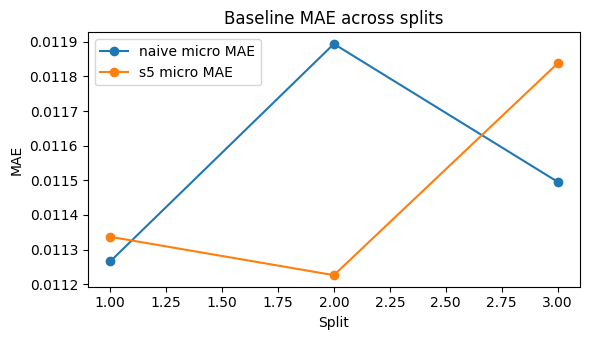

In [44]:
import pandas as pd, matplotlib.pyplot as plt, pathlib
pathlib.Path("docs/figs").mkdir(parents=True, exist_ok=True)

summary = pd.read_csv("reports/baselines_rollingorigin_summary.csv")
plt.figure(figsize=(6,3.5))
for method, g in summary.groupby("method"):
    plt.plot(g["split"], g["micro_mae"], marker="o", label=f"{method} micro MAE")
plt.xlabel("Split"); plt.ylabel("MAE"); plt.title("Baseline MAE across splits")
plt.legend(); plt.tight_layout()
plt.savefig("docs/figs/baselines_mae_splits.png", dpi=200)
"Saved docs/figs/baselines_mae_splits.png"

### Part C — Add a quick test to protect the splitter

In [45]:
# save to tests/test_rolling_splitter.py
import pandas as pd, numpy as np
from datetime import timedelta

def make_splits(dates, train_min, val_size, step, embargo):
    u = np.array(sorted(pd.to_datetime(dates.unique()))); n=len(u); out=[]; i=train_min-1
    while True:
        if i>=n: break
        a,b = u[0], u[i]; vs=i+embargo+1; ve=vs+val_size-1
        if ve>=n: break
        out.append((a,b,u[vs],u[ve])); i+=step
    return out

def test_embargo_and_order():
    dates = pd.bdate_range("2024-01-01", periods=400)
    s = make_splits(pd.Series(dates), 252, 63, 63, 5)
    assert all(b < c for (a,b,c,d) in s), "Embargo/order violated"
    # Splits should move forward
    assert len(s) >= 2 and s[1][1] > s[0][1]

In [46]:
%%bash
pytest -q -k rolling_splitter

.                                                                        [100%]


### Part D — (Optional) Makefile targets
Add the following to the Makefile
``` make
.PHONY: baselines
baselines: ## Evaluate naive & seasonal-naive baselines across all splits
\tpython scripts/baselines_eval.py --seasonality 5
```

In [47]:
# refer to lec14-inclass.ipynb how to add this using Python code

from pathlib import Path
mk = Path("Makefile")
text = mk.read_text() if mk.exists() else ""
if "baselines" not in text:
    text += """

.PHONY: baselines
baselines: ## Evaluate naive & seasonal-naive baselines across all splits
\tpython scripts/baselines_eval.py --seasonality 5
"""
mk.write_text(text)
print(mk.read_text())

# Makefile — unified-stocks
SHELL := /bin/bash
.SHELLFLAGS := -eu -o pipefail -c
.ONESHELL:


PY := python
QUARTO := quarto

START ?= 2020-01-01
END   ?= 2025-08-01
ROLL  ?= 30

DATA_RAW := data/raw/prices.csv
FEATS    := data/processed/features.parquet
REPORT   := docs/reports/eda.html

# Default target
.DEFAULT_GOAL := help

.PHONY: help all clean clobber qa report backup

help: ## Show help for each target
	@awk 'BEGIN {FS = ":.*##"; printf "Available targets:\n"} /^[a-zA-Z0-9_\-]+:.*##/ {printf "  \033%-18s\033 %s\n", $$1, $$2}' $(MAKEFILE_LIST)

# all: $(DATA_RAW) $(FEATS) report backup ## Run the full pipeline and back up artifacts
all: $(DATA_RAW) $(FEATS) report train backup

$(DATA_RAW): scripts/get_prices.py tickers_25.csv
	$(PY) scripts/get_prices.py --tickers tickers_25.csv --start $(START) --end $(END) --out $(DATA_RAW)

$(FEATS): scripts/build_features.py $(DATA_RAW) scripts/qa_csv.sh
	# Basic QA first
	scripts/qa_csv.sh $(DATA_RAW)
	$(PY) scripts/build_features.py --inpu

## Key points

-   **Define the problem first** (H, step, splits); metrics only make sense after framing.
-   **MASE \< 1** ⇒ better than naïve; report both macro & micro.
-   **Embargo** helps mitigate adjacency leakage; keep it small but nonzero.